# Neural Networks

Welcome to this exercise. We'll see how to recognize digits using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset! <br>
Don't worry if you don't understand most of the code! You'll get there soon. <br>
We will write some GUI for the interface and some cool neural network! <br>

### Let's get started!

In [1]:
# set warnings off
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
# imports
import numpy as np
import tkinter as tk
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from random import randrange
from PIL import Image, ImageDraw

Using TensorFlow backend.


We just imported the required modules. It's time to load the dataset!

In [2]:
# seed is to ensure that we generate the same stuff every time
seed = 7
np.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_pixels = X_train.shape[1] * X_train.shape[2]

Wait, we just loaded the dataset, but we don't know what it looks like yet! Run the snippet below to see 9 random images from the dataset.

In [3]:
X_train[1].shape

(28, 28)

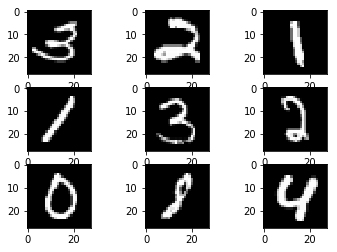

In [4]:
num_plot = 9
# plot random figures
for i in range(num_plot):
    plt.subplot(num_plot**0.5, num_plot**0.5, i+1)
    plt.imshow(X_train[randrange(len(X_train))], cmap=plt.get_cmap("gray"))
plt.show()

This data is raw and cannot be straightaway fed to our network. We need to preprocess it first!

In [5]:
# flatten images to vector
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype("float32")
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype("float32")

# normalize inputs
X_train = X_train/255
X_test = X_test/255

# one hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_train.shape[1]

We now need to define a neural network to run this stuff! Let's create a basic network with Keras!

In [6]:
# create
model = Sequential()

model.add(Dense(256, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


We have defined our neural network. Here's a [tool](http://alexlenail.me/NN-SVG/index.html) to visualize it! <br>
If we had images of 4x4 pixels with hidden layers of 12 nodes, the neural network would look like this:<br>
![image](../../Media/neural_networks.png) <br>
Next, we will train the model on the preprocessed data!

In [7]:
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=200,
          verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 0.3360 - acc: 0.9070 - val_loss: 0.1505 - val_acc: 0.9549
Epoch 2/10
 - 3s - loss: 0.1203 - acc: 0.9644 - val_loss: 0.1094 - val_acc: 0.9651
Epoch 3/10
 - 4s - loss: 0.0773 - acc: 0.9771 - val_loss: 0.0774 - val_acc: 0.9759
Epoch 4/10
 - 4s - loss: 0.0536 - acc: 0.9839 - val_loss: 0.0678 - val_acc: 0.9777
Epoch 5/10
 - 4s - loss: 0.0410 - acc: 0.9872 - val_loss: 0.0762 - val_acc: 0.9763
Epoch 6/10
 - 5s - loss: 0.0299 - acc: 0.9906 - val_loss: 0.0684 - val_acc: 0.9784
Epoch 7/10
 - 4s - loss: 0.0239 - acc: 0.9924 - val_loss: 0.0675 - val_acc: 0.9785
Epoch 8/10
 - 3s - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0817 - val_acc: 0.9785
Epoch 9/10
 - 3s - loss: 0.0144 - acc: 0.9958 - val_loss: 0.0847 - val_acc: 0.9789
Epoch 10/10
 - 4s - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0715 - val_acc: 0.9813
Error: 1.87%


Here's a simple app to draw stuff on and predict the digit!

In [8]:
class RecognizerApp:
    
    def __init__(self, model):
        self.DRAWING_AREA = (280, 280)
        self.predictions = [0 for x in range(10)]
        self.model = model
        self.first = False
        self.image = self.new_image()
        self.drawer = ImageDraw.Draw(self.image)
        # create the canvas
        master = tk.Tk()
        master.title("Digit recognizer")
        clear = tk.Button(master, text="CLEAR", command=self._clear_)
        clear.pack(side=tk.BOTTOM)
        self.canvas = tk.Canvas(master,
                   width=self.DRAWING_AREA[0],
                   height=self.DRAWING_AREA[1])
        self.canvas.configure(background="black")
        self.canvas.pack()
        self.canvas.bind("<B1-Motion>", self._paint_)
        self.canvas.bind("<ButtonRelease-1>", self._update_)
    
    def config_plot(self):
        plt.xlabel('Digits')
        plt.ylabel('Probability')
        plt.title('Predictions')
        plt.bar(range(0, 10), recognizer.get_predictions())
        plt.show()
        self.first = False
        
    def new_image(self):
        return Image.new("L", self.DRAWING_AREA)

    def _paint_(self, event):
        x1, y1 = (event.x - 5), (event.y - 5)
        x2, y2 = (event.x + 5), (event.y + 5)
        
        self.canvas.create_oval(x1, y1, x2, y2, fill="#FFFFFF", outline="")
        self.drawer.ellipse([x1, y1, x2, y2], fill=255, outline=255)
        
        temp_image = self.image.copy()
        temp_image.thumbnail((28, 28), Image.ANTIALIAS)
        temp_image = img_to_array(temp_image)
        temp_image = np.reshape(temp_image, (1, 28 * 28))
        
        self.predictions = self.model.predict(temp_image)[0].tolist()

    def _update_(self, event):
        if self.first:
            self.config_plot()
        else:
            plt.cla()
            plt.bar(range(0, 10), self.predictions)
            plt.draw()

    def _clear_(self):
        if self.first:
            self.config_plot()
        else:
            self.canvas.delete("all")
            self.predictions = [0 for x in range(10)]
            self.image = self.new_image()
            self.drawer = ImageDraw.Draw(self.image)
            plt.cla()
            plt.draw()
        
    def get_predictions(self):
        return self.predictions
    
    def mainloop(self):
        tk.mainloop()

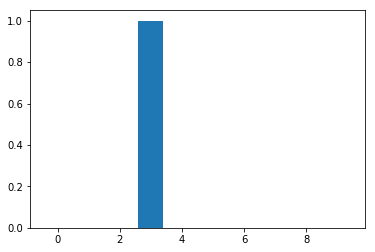

In [9]:
recognizer = RecognizerApp(model)
recognizer.mainloop()